In [2]:
import json
import pandas as pd
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
# from matplotlib import colors as mplcol
# import seaborn
# mpl.style.use('ggplot')
%matplotlib inline
# from pprint import pprint

def get_gen_df(xl, it, dig=2):
    sh_name = ('iter_%0' + str(dig) + 'd') % it
    gen_df = pd.read_excel(xl, sheetname=sh_name)
    gen_df['iter'] = it
    return gen_df

In [3]:
res_dir = r"C:\Users\admin\Desktop\AXA\optim_paper\results" #\paper_choice"
# case_name = 'new39_scopf_exp_080_50pos30fix01step1oos0olDcost1orr'
case_name = r'new39_opf_exp_095_50pos30fix001step1oos0olBcost1orr1zip0wlw1agc'
res_path = os.path.join(res_dir, case_name, case_name + '_results.json')
gen_path = os.path.join(res_dir, case_name, case_name + '_gen_data.xlsx')
iter_list = None

if res_path.endswith('json'):
    res_file = open(res_path, 'r')
    res_json = json.load(res_file)
    res_df = pd.DataFrame(res_json)
elif res_path.endswith('xlsx'):
    res_df = pd.read_excel(res_path)
else:
    res_df = None
    print 'Bad results file!!!'

iter_list = iter_list if iter_list else res_df.iter.tolist()
gen_dfs = [ get_gen_df(gen_path, it, dig=3) for it in iter_list ]
gen_df = pd.concat(gen_dfs)

# Results

In [4]:
plt.rcParams.update({'font.size': 10})
# iter_lims = (0, 75)
iter_lims = (0, max(res_df.iter))
iter_xlims = [ it + 0.5*(-1)**(i+1) for i, it in enumerate(iter_lims)]

plt.rcParams.update({'font.size': 24, 'font.family': 'serif'})

## Costs
### Market, risk-based and total

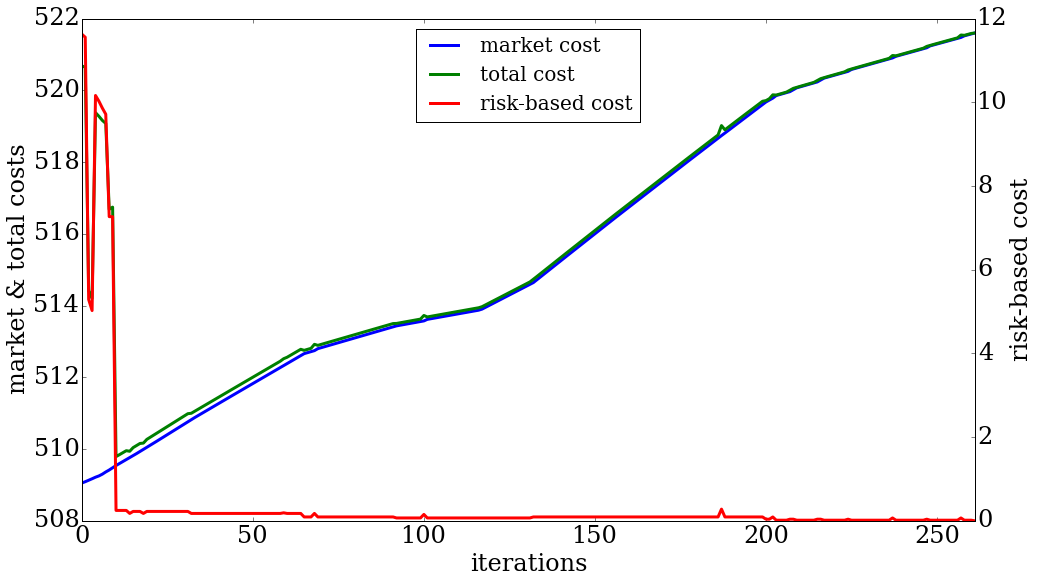

In [5]:
# prepare the plot...
fig, ax_cost = plt.subplots(figsize=(16,9))

ax_cost.set_xlabel('iterations')
ax_cost.set_xlim(iter_xlims)
ax_cost.plot(res_df.iter, res_df.cost, 'b-', label='market cost', linewidth=3)
ax_cost.plot(res_df.iter, res_df.total, 'g-', label='total cost', linewidth=3)
ax_cost.set_ylabel('market & total costs')
ax_risk = ax_cost.twinx()
ax_risk.set_xlim(iter_lims)
ax_risk.plot(res_df.iter, res_df.risk, 'r-', label='risk-based cost', linewidth=3)
ax_risk.set_ylabel('risk-based cost')
# legend
h_cost, l_cost = ax_cost.get_legend_handles_labels()
h_risk, l_risk = ax_risk.get_legend_handles_labels()
ax_cost.legend(h_cost+h_risk, l_cost+l_risk, loc='upper center', fontsize=20)
# show
# fig.tight_layout()
plt.savefig(os.path.join(res_dir, case_name, case_name + '_all_costs.png'))
plt.show()

### Risk-based costs by type

#### Stacked

c:\winpython-64bit-2.7.9.5\python-2.7.9.amd64\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


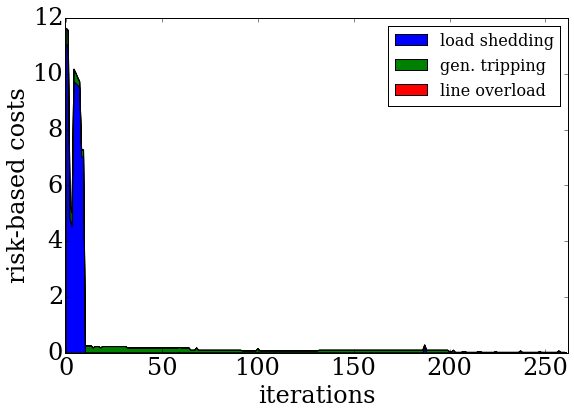

In [6]:
fig, ax = plt.subplots(figsize=(9,6))
ax.set_xlabel('iterations')
ax.set_ylabel('risk-based costs')
ax.set_xlim(iter_xlims)
labels=['load shedding', 'gen. tripping', 'line overload']
colors=['blue', 'green', 'red']
ax.stackplot(res_df.iter, res_df.risk_lsd, res_df.risk_oos, res_df.risk_ovl, colors=colors)
handles = [ Rectangle((0, 0), 1, 1, fc=color) for color in colors ]
# fig.legend(handles=handles, labels=labels, loc=0, fontsize=16)
ax.legend(handles, labels, loc=0, fontsize=16)
plt.show()

#### Separated

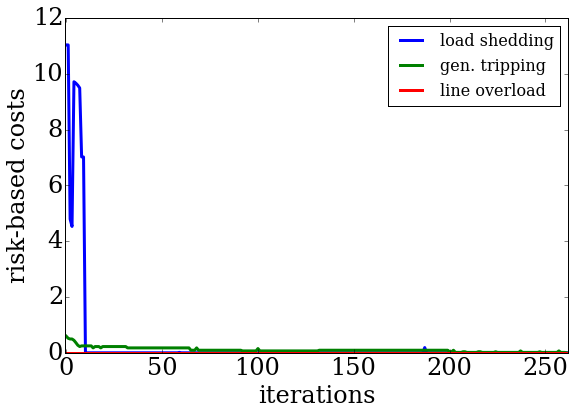

In [7]:
fig, ax = plt.subplots(figsize=(9,6))
ax.set_xlabel('iterations')
ax.set_ylabel('risk-based costs')
ax.set_xlim(iter_xlims)
ax.plot(res_df.iter, res_df.risk_lsd, 'b-', label=labels[0], linewidth=3)
ax.plot(res_df.iter, res_df.risk_oos, 'g-', label=labels[1], linewidth=3)
ax.plot(res_df.iter, res_df.risk_ovl, 'r-', label=labels[2], linewidth=3)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc=0, fontsize=16)
plt.show()


## Dispatch
### Generation power

In [8]:
gen_pgen_df = gen_df.pivot(index='iter', columns='g_oos', values='g_pgen')
gen_CM_df = gen_df.pivot(index='iter', columns='g_oos', values='g_CM')
gen_trips_df = gen_df.pivot(index='iter', columns='g_oos', values='g_trips')

gen_names = sorted(gen_pgen_df.keys())
num_gens = len(gen_names)
col_names = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']
# gen_cmap = plt.cm.get_cmap('Dark2')
# gen_cmap.set
# col_names = plt.cm.Set1(range(num_gens*25))[0:25*num_gens:25]
# col_names = [ gen_cmap(gen) for gen in gen_names ]
gen_colors = dict(zip(gen_names, col_names))

init_pmax = [ 1100.0, 646.0, 725.0, 917.0, 508.0, 800.0, 816.0, 564.0, 865.0, 1040.0 ]
gen_pmaxes = dict(zip(gen_names, init_pmax))
init_costs = list(gen_dfs[0].sort_values('g_oos').g_gencost)
gen_costs = dict(zip(gen_names, init_costs))

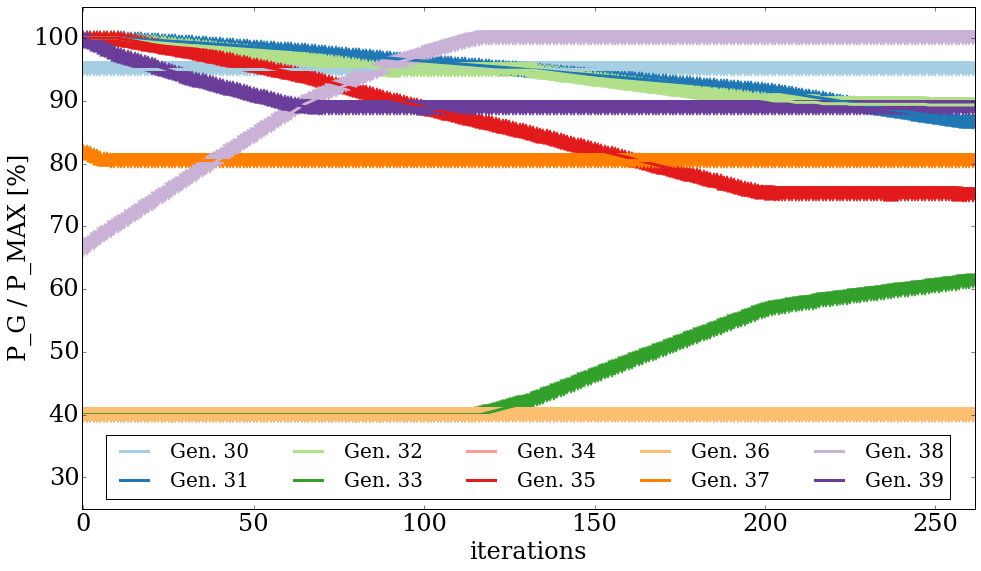

In [9]:
fig, ax = plt.subplots(figsize=(16,9))
ax.set_xlabel('iterations')
ax.set_ylabel('P_G / P_MAX [%]')
ax.set_xlim(iter_xlims)
ax.set_ylim((25, 105))

for gen in gen_names:
    for it in range(iter_lims[0], iter_lims[1]+1):
        ax.scatter(gen_pgen_df.index[it], 100 * gen_pgen_df[gen][it] / gen_pmaxes[gen], color=gen_colors[gen],
                   marker='^' if gen_CM_df[gen][it] else 'v', s=200)
        
    ax.plot(gen_pgen_df.index, 100 * gen_pgen_df[gen] / gen_pmaxes[gen], color=gen_colors[gen],
            label='Gen. %d' % gen, linewidth=3)

# handles = [ Rectangle((0, 0), 1, 1, fc=gen_colors[gen]) for gen in gen_names ]
# labels = [ 'Gen. %d - P_MAX = %.0f, Cost = %d' % (gen, gen_pmaxes[gen], gen_costs[gen]) for gen in gen_names ]
# labels = [ 'Gen. %d' % gen for gen in gen_names ]
handles, labels = ax.get_legend_handles_labels()
# for handle in handles:
#     handle.set_linewidth(5)
ax.legend(handles=handles, labels=labels, loc='lower center', ncol=num_gens/2, fontsize=20)
plt.savefig(os.path.join(res_dir, case_name, case_name + '_gen_power.png'))
plt.show()

### Number of gen. trips

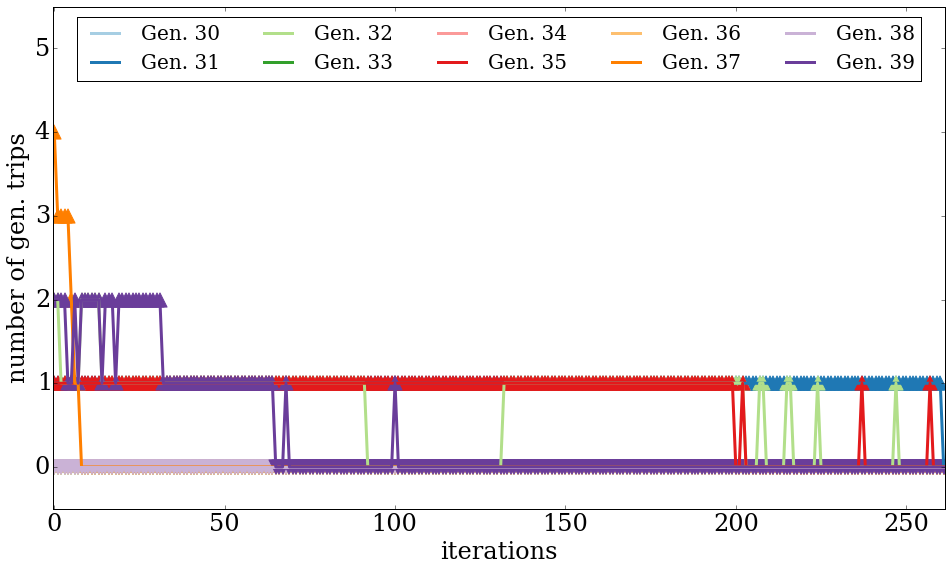

In [10]:
fig, ax = plt.subplots(figsize=(16,9))
ax.set_xlabel('iterations')
ax.set_ylabel('number of gen. trips')
ax.set_xlim(iter_xlims)
for gen in gen_names:
    for it in range(iter_lims[0], iter_lims[1]+1):
        ax.scatter(gen_trips_df.index[it], gen_trips_df[gen][it], color=gen_colors[gen],
                   marker='^' if gen_CM_df[gen][it] else 'v', s=200)
        
    ax.plot(gen_pgen_df.index, gen_trips_df[gen], color=gen_colors[gen],
           label='Gen. %d' % gen, linewidth=3)

ax.set_ylim((-0.5, ax.get_ylim()[1]+0.5))

    
# handles = [ Rectangle((0, 0), 1, 1, fc=gen_colors[gen]) for gen in gen_names ]
# labels = [ 'Gen. %d - P_MAX = %.0f, Cost = %d' % (gen, gen_pmaxes[gen], gen_costs[gen]) for gen in gen_names ]
# fig.legend(handles=handles, labels=labels, loc=0)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper center', ncol=num_gens/2, fontsize=20)
plt.savefig(os.path.join(res_dir, case_name, case_name + '_gen_trips.png'))
plt.show()

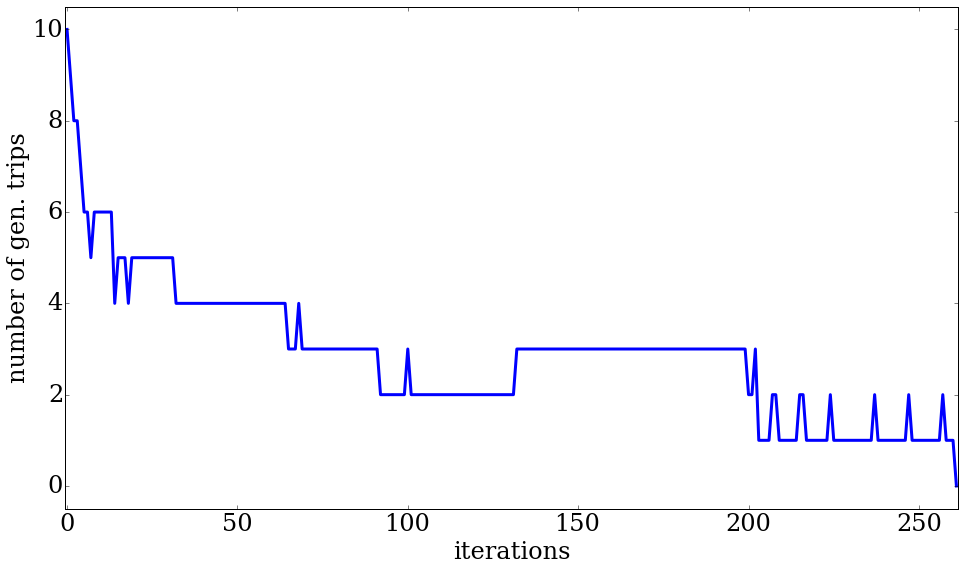

In [11]:
if 'tot' not in gen_trips_df.columns:
    gen_trips_df['tot'] = gen_trips_df.sum(axis=1)

fig, ax = plt.subplots(figsize=(16,9))
ax.set_xlabel('iterations')
ax.set_ylabel('number of gen. trips')
ax.set_xlim(iter_xlims)
ax.plot(gen_trips_df.index, gen_trips_df['tot'], linewidth=3)
ax.set_ylim((-0.5, ax.get_ylim()[1]+0.5))
    
plt.savefig(os.path.join(res_dir, case_name, case_name + '_all_gen_trips.png'))
plt.show()

# Tests

In [12]:
opf_name = 'opf'
base_name = r'new39_' + opf_name + '_exp_095_50pos30fix%sstep1oos0olBcost1orr1zip0wlw1agc'
results = dict()
steps = [5,2,1,0.5,0.2,0.1]
for step in steps:
    step_str = '%03d' % (10*step)
    case_name = base_name % step_str
    try:
        res_path = os.path.join(res_dir, case_name, case_name + '_results.xlsx')
        res_df = pd.read_excel(res_path)
    except IOError:
        res_path = os.path.join(res_dir, case_name, case_name + '_results.json')
        res_df = pd.DataFrame(json.load(open(res_path, 'r')))

    results[step] = dict()
    results[step]['df'] = res_df
    results[step]['min_iter'] = res_df.total.idxmin()
    results[step]['min_cost'] = res_df.total.min()
    results[step]['fin_iter'] = res_df.index.max()
    results[step]['fin_cost'] = res_df.total.values[-1]
    results[step]['ini_cost'] = res_df.total.values[0]
    results[step]['ini_risk'] = res_df.risk.values[0]


In [13]:
results_columns = ['min_cost',  'fin_cost',  'min_iter',  'fin_iter']
sens_anal_df = pd.DataFrame([{
    'step': step,
#     'ini_risk': results[step]['ini_risk'],
#     'ini_cost': results[step]['ini_cost'],
    'min_cost': round(results[step]['min_cost'], 2),
    'fin_cost': round(results[step]['fin_cost'], 2),
    'min_iter': int(results[step]['min_iter']),
    'fin_iter': int(results[step]['fin_iter']),
} for step in steps])
sens_anal_df.set_index('step', inplace=True)
sens_anal_df = sens_anal_df[results_columns]
sens_anal_df.to_excel(os.path.join(res_dir, 'new39_' + opf_name + '_exp_095_sens_anal.xlsx'), sheet_name=opf_name.upper())
sens_anal_df

min_cost  fin_cost  min_iter  fin_iter
step                                        
5.0     512.19    527.12         1         7
2.0     510.36    523.32         1        14
1.0     509.76    522.54         1        27
0.5     509.77    522.12         2        52
0.2     509.81    521.75         5       131
0.1     509.79    521.60        10       261